# Data 620 - Project 3
Baron Curtin, Heather Geiger, Mikhail Groysman, Betsy Rosalen 

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python,
and any features you can think of, build the best name gender classifier you can.

Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the devtest set, and the remaining 6900 words for the training set. Then, starting with the example name gender
classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are
satisfied with your classifier, check its final performance on the test set.

How does the performance on the test set compare to the performance on the dev-test set? Is this what
you'd expect? 

In [1]:
# library imports
import random
from collections import Counter
from nltk import download
from nltk.corpus import names
from nltk.util import ngrams
from nltk.tokenize.sonority_sequencing import SyllableTokenizer
from nltk import NaiveBayesClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

# jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Data Loading/Preparation
In the following cells, we will be loading the corpus into memory, labelling all of the names, and then randomizing the
list of names for later use. Randomizing the names will ensure that our training/test sets will contain both genders from 
which we should be able to create numerous features from.

In [2]:
# read in names from the files
# label each name with corresponding gender
# names to be lowercase for easy recognition 
download('names')
males = [(name.lower().strip(), 'male') for name in names.words('male.txt')]

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\m_gro\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


True

In [3]:
males[:5]

[('aamir', 'male'),
 ('aaron', 'male'),
 ('abbey', 'male'),
 ('abbie', 'male'),
 ('abbot', 'male')]

In [4]:
females = [(name.lower().strip(), 'female') for name in names.words('female.txt')]

# combine lists of names
all_names = males + females

all_names1=[]
for (i,tag) in all_names:
    for (j,tag1) in all_names:
        if i==j and tag1!=tag:
            tag='unisex'
    all_names1.append((i,tag))

all_names2=[]
for i in all_names1:
  if i not in all_names2:
    all_names2.append(i)            
            

In [5]:
all_names2[:5]

[('aamir', 'male'),
 ('aaron', 'male'),
 ('abbey', 'unisex'),
 ('abbie', 'unisex'),
 ('abbot', 'male')]

In [6]:
all_names=all_names2

## Feature Creation
Features are the most important part of what goes into a machine learning model. For that reason, it is critically important
to try to come up with features that make the most sense in identifying gender differences in names. To make creation and analysis easier,
we will put our data in a Pandas dataframe.

In [7]:
# create dataframe
data = pd.DataFrame(all_names, columns=['name','gender'])
#data = pd.DataFrame.from_dict(dict(all_names), orient='index', columns=['gender']).reset_index()
#data.columns = ['name', 'gender']
#data.head()
#data[data['name']=='whitney']

In [8]:
# instatiate syllable tokenize
SSP = SyllableTokenizer()

# create various feature columns for exploration
data['length'] = data['name'].str.len()
data['first_letter'] = data['name'].str[0]
data['last_letter'] = data['name'].str[-1]
data['vowel_last_letter'] = data['last_letter'].isin([*'aeiou'])
data['vowel_first_letter'] = data['first_letter'].isin([*'aeiou'])
data['vowels'] = data['name'].str.replace(r'[^aeiou]', '')
data['consonants'] = data['name'].str.replace(r'[aeiou]', '')
data['vowel_count'] = data['vowels'].str.len()
data['consonant_count'] = data['consonants'].str.len()
data['bigrams'] = data['name'].apply(lambda x: list(ngrams(x, 2)))
data['trigrams'] = data['name'].apply(lambda x: list(ngrams(x, 3)))
data['syllables'] = data['name'].apply(lambda x: len(SSP.tokenize(x)))

# preview data
data.head()

C:\Users\m_gro\Anaconda3\lib\site-packages\nltk\tokenize\sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))


,name,gender,length,first_letter,last_letter,vowel_last_letter,vowel_first_letter,vowels,consonants,vowel_count,consonant_count,bigrams,trigrams,syllables
0,aamir,male,5,a,r,False,True,aai,mr,3,2,"[(a, a), (a, m), (m, i), (i, r)]","[(a, a, m), (a, m, i), (m, i, r)]",2
1,aaron,male,5,a,n,False,True,aao,rn,3,2,"[(a, a), (a, r), (r, o), (o, n)]","[(a, a, r), (a, r, o), (r, o, n)]",2
2,abbey,unisex,5,a,y,False,True,ae,bby,2,3,"[(a, b), (b, b), (b, e), (e, y)]","[(a, b, b), (b, b, e), (b, e, y)]",2
3,abbie,unisex,5,a,e,True,True,aie,bb,3,2,"[(a, b), (b, b), (b, i), (i, e)]","[(a, b, b), (b, b, i), (b, i, e)]",2
4,abbot,male,5,a,t,False,True,ao,bbt,2,3,"[(a, b), (b, b), (b, o), (o, t)]","[(a, b, b), (b, b, o), (b, o, t)]",2


In [9]:
# lets analyze our bigrams and trigrams columns to get the most common ngrams by gender
ngrams_gender = data.groupby('gender')[['bigrams', 'trigrams']].sum()
ngrams_gender['bigrams_counter'] = ngrams_gender['bigrams'].apply(lambda x: Counter(x))
ngrams_gender['trigrams_counter'] = ngrams_gender['trigrams'].apply(lambda x: Counter(x))
ngrams_gender

,bigrams,trigrams,bigrams_counter,trigrams_counter
gender,,,,
female,"[(a, b), (b, a), (a, g), (g, a), (a, e), (e, l...","[(a, b, a), (b, a, g), (a, g, a), (g, a, e), (...","{('a', 'b'): 95, ('b', 'a'): 48, ('a', 'g'): 3...","{('a', 'b', 'a'): 7, ('b', 'a', 'g'): 2, ('a',..."
male,"[(a, a), (a, m), (m, i), (i, r), (a, a), (a, r...","[(a, a, m), (a, m, i), (m, i, r), (a, a, r), (...","{('a', 'a'): 7, ('a', 'm'): 81, ('m', 'i'): 65...","{('a', 'a', 'm'): 1, ('a', 'm', 'i'): 10, ('m'..."
unisex,"[(a, b), (b, b), (b, e), (e, y), (a, b), (b, b...","[(a, b, b), (b, b, e), (b, e, y), (a, b, b), (...","{('a', 'b'): 7, ('b', 'b'): 8, ('b', 'e'): 8, ...","{('a', 'b', 'b'): 5, ('b', 'b', 'e'): 1, ('b',..."


Using the counter class and the bigrams and trigrams, we can eliminate the need for the most common bigram/trigram and instead
just use the list of bigrams and trigrams as features. The most common bigram was only in ~13% of the female names and ~12%
of the male names.

## Data Exploration
Lets get a better feel for how our data is composed. In this exploration step, we will confirm whether any of the features
we created will become good predictors of gender. Exploration will occur both visually as well as computationally.

In [655]:
# use our created variables to generate some summary statistics
data.groupby('gender').mean()

,length,vowel_last_letter,vowel_first_letter,vowel_count,consonant_count,syllables
gender,,,,,,
female,6.187392,0.737263,0.176382,2.701857,3.485535,2.498273
male,5.995733,0.224593,0.159426,2.221102,3.774631,2.061676
unisex,5.186301,0.397260,0.109589,1.989041,3.197260,1.884932


In [10]:
# separate features from label
X = data.drop(columns=['name', 'gender'])
y = data['gender']

Based on the above chart, we see that females have a higher name length on average, higher vowel counts, and the last letter is 72% of the time a vowel.
These appear to be good predictors. We need to visual confirm what we see numerically

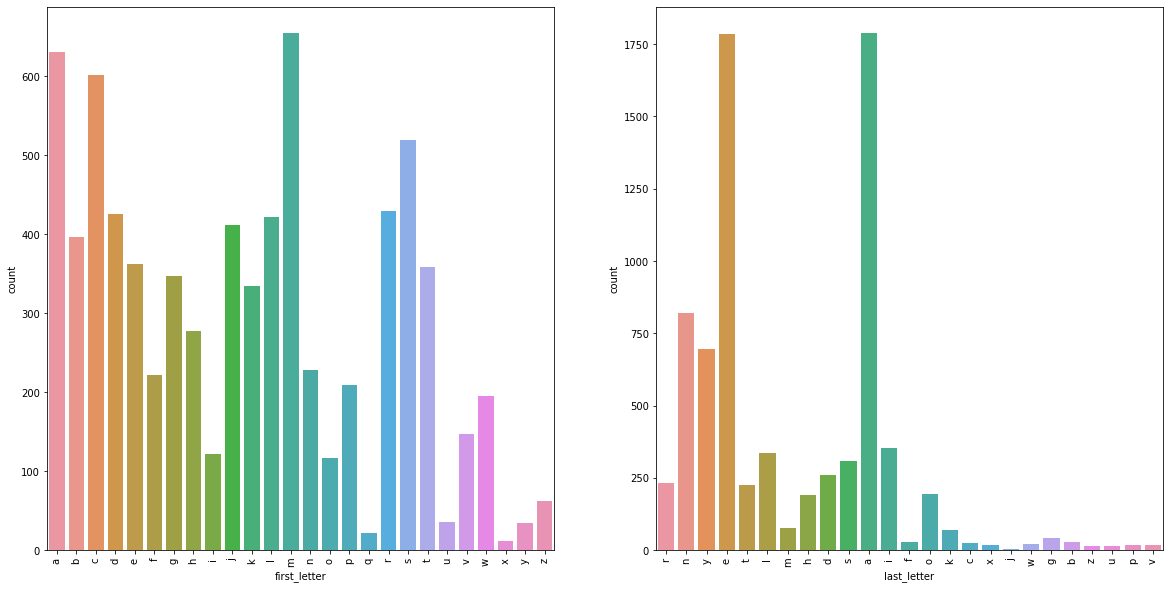

In [11]:
# categorical/numerical columns
categorical_cols = X.loc[:, [col for col in X.columns if 'gram' not in col]].select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=np.number).columns

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for var, subplot in zip(categorical_cols[:2], ax.flatten()):
    sns.countplot(x=var, data=data, ax=subplot)
    # rotate labels for easy viewing
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

The distributions above don't tell us much. We need to condition on gender.

C:\Users\m_gro\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


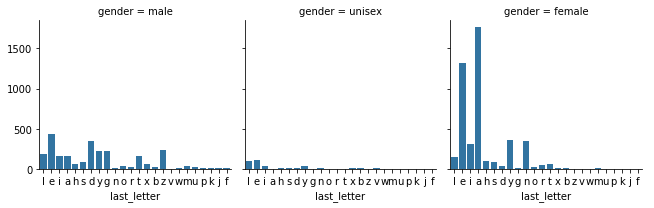

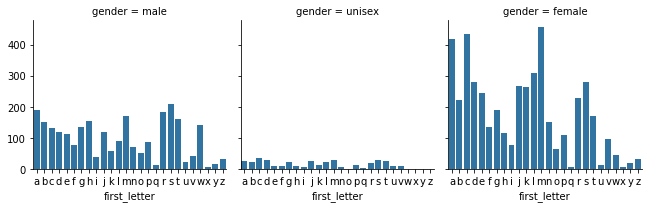

In [12]:
cond_plot = sns.FacetGrid(data=data, col='gender')
cond_plot.map(sns.countplot, 'last_letter').add_legend()
plt.tight_layout()
plt.show()

cond_plot = sns.FacetGrid(data=data, col='gender')
cond_plot.map(sns.countplot, 'first_letter').add_legend()
plt.tight_layout()
plt.show()

It would appear that both the first and the last letter could be pretty good predictors for gender.

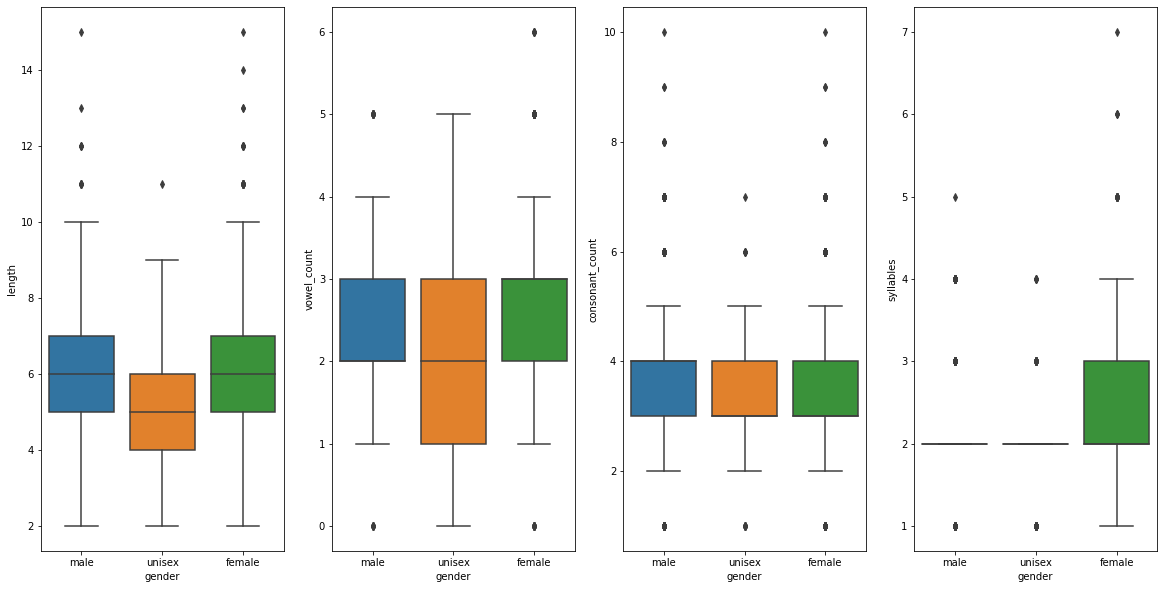

In [13]:
# numerical columns to gender exploration
fig, ax = plt.subplots(1, 4, figsize=(20, 10))

for var, subplot in zip(numerical_cols, ax.flatten()):
    sns.boxplot(x='gender', y=var, data=data, ax=subplot)
    

From the boxplots above, we can safely rule out vowel count, consonant count, and length as strong predictors of gender.  Syllables, however, seems like it may be a good predictor.

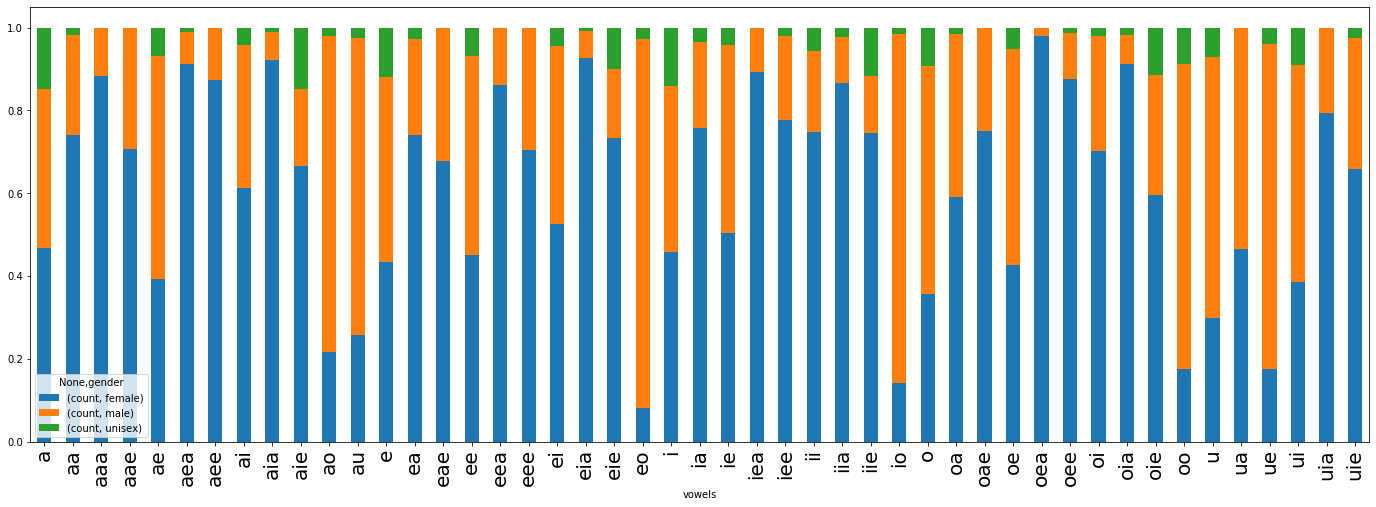

In [62]:

data2=data[['vowels', 'gender', 'name']].groupby(['vowels', 'gender']).agg(['count'])
data2.reset_index(inplace=True)
data3=data[['vowels', 'name']].groupby(['vowels']).agg(['count'])
data3.reset_index(inplace=True)
data2.columns=['vowels','gender','count']
data3.columns=['vowels','tcount']
data4=data2.merge(data3, left_on='vowels', right_on='vowels')
data5=data4.sort_values(by=['tcount'], ascending=False)
data5=data5[:130]
tps2 = data5.pivot_table(values=['count'], 
                      index='vowels',
                      columns='gender',
                      aggfunc='sum')


tps2 = tps2.div(tps2.sum(1), axis=0)
tps2.plot(kind='bar', stacked=True)

plt.gcf().set_size_inches(24, 8)

In [42]:
tps2[tps2.iloc[:,1]>0.8]

count                    
gender    female      male    unisex
vowels                              
eo      0.081081  0.891892  0.027027
iea          NaN  1.000000       NaN
io      0.140625  0.843750  0.015625

I will use 80% as cutoff point for good indicator. For females, good indicators are 'aaa','aaea','aaee','aaia','aaie','aea','aee','aea','aee','aia','eea','eia','iia','oea','oee','oia'. For males, good indicators are 'eo','iea','io'. No strong indicator for unisex names.

### Last Letters

Last letters as indicated by our text book as well as this [article](https://www.huggies.com/en-us/tips-advice/celebration-planning/baby-names/masculine-and-feminine-versions-of-baby-names) are good predictors of gender of names.

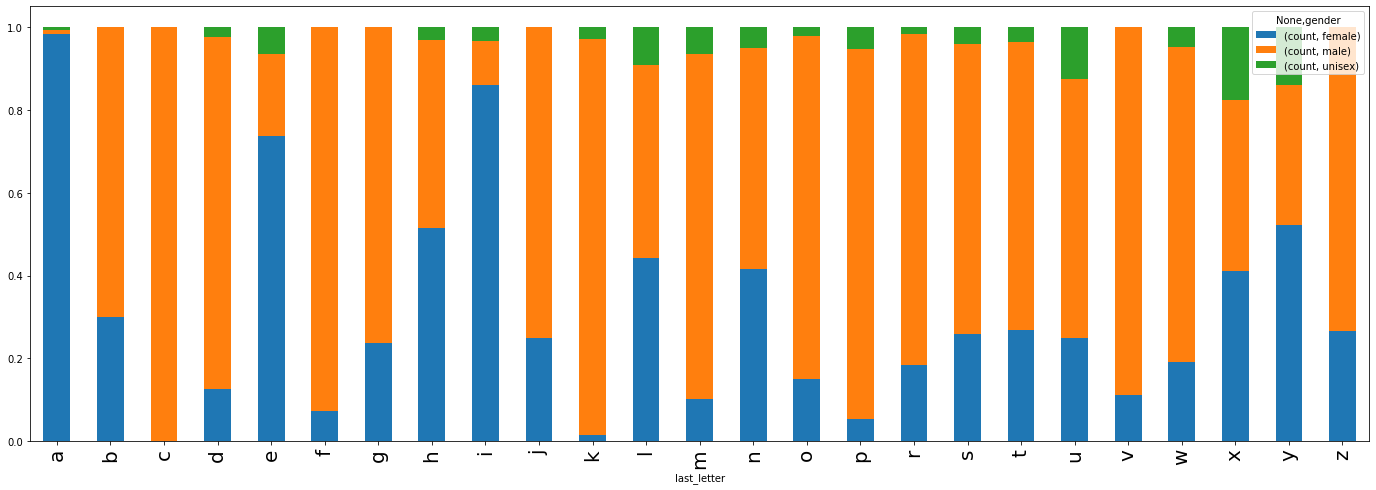

In [660]:
data1=data[['last_letter', 'gender', 'name']].groupby(['last_letter', 'gender']).agg(['count'])
data1.reset_index(inplace=True)
data1.columns = ['last_letter','gender','count']
tps = data1.pivot_table(values=['count'],index='last_letter',columns='gender',aggfunc='sum')
tps = tps.div(tps.sum(1), axis=0)
import matplotlib
matplotlib.rc('xtick', labelsize=20)  
%matplotlib inline 
tps.plot(kind='bar', stacked=True)
plt.gcf().set_size_inches(24, 8)


I will use 80% as cutoff point for good indicator. For females, good indicators are 'a' and 'i'. For males, good indicators are 'c', 'd', 'f', 'k', 'm', 'o', 'p', 'v', and 'w'. No strong indicator for unisex names.

### Last 2 letters.

Last 2 letters are good indicators as well. They might be even be better as they are more specific.

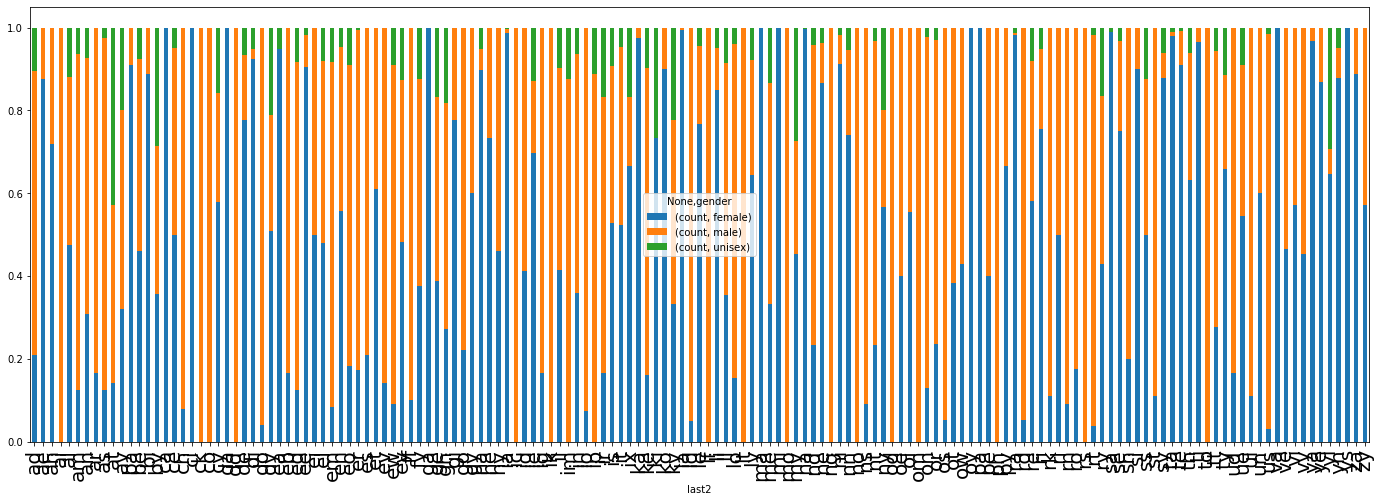

In [1075]:
data['last2']= data['name'].str[-2:]
data2=data[['last2', 'gender', 'name']].groupby(['last2', 'gender']).agg(['count'])
data2.reset_index(inplace=True)
data3=data[['last2', 'name']].groupby(['last2']).agg(['count'])
data3.reset_index(inplace=True)
data2.columns=['last2','gender','count']
data3.columns=['last2','tcount']
data4=data2.merge(data3, left_on='last2', right_on='last2')
data5=data4.sort_values(by=['tcount'], ascending=False)
data5=data5[:350]
tps2 = data5.pivot_table(values=['count'], 
                      index='last2',
                      columns='gender',
                      aggfunc='sum')


tps2 = tps2.div(tps2.sum(1), axis=0)
tps2.plot(kind='bar', stacked=True)

plt.gcf().set_size_inches(24, 8)

In [1047]:
tps2[tps2.iloc[:,0]>0.9]

count                    
gender    female      male    unisex
last2                               
ca      1.000000       NaN       NaN
da      1.000000       NaN       NaN
di      0.923077  0.025641  0.051282
ea      0.947368       NaN  0.052632
ee      0.904348  0.078261  0.017391
ia      0.987952  0.008032  0.004016
ka      0.975000  0.025000       NaN
la      0.995050  0.004950       NaN
ma      1.000000       NaN       NaN
mi      1.000000       NaN       NaN
na      0.995495  0.002252  0.002252
ni      0.912281  0.070175  0.017544
ra      0.981707  0.006098  0.012195
sa      0.989362       NaN  0.010638
ta      0.980392  0.009804  0.009804
te      0.909774  0.082707  0.007519
ti      0.964286  0.035714       NaN
va      1.000000       NaN       NaN
ya      0.966667  0.033333       NaN

In [1076]:
tps2[tps2.iloc[:,1]>0.9]

count                    
gender    female      male    unisex
last2                               
ai           NaN  1.000000       NaN
ch      0.080000  0.920000       NaN
ck           NaN  1.000000       NaN
co           NaN  1.000000       NaN
dd           NaN  1.000000       NaN
do      0.040000  0.960000       NaN
ic           NaN  1.000000       NaN
ik           NaN  1.000000       NaN
io      0.074074  0.925926       NaN
ld      0.051282  0.948718       NaN
lf           NaN  1.000000       NaN
lt           NaN  1.000000       NaN
mo           NaN  1.000000       NaN
ng           NaN  1.000000       NaN
no           NaN  1.000000       NaN
ns      0.090909  0.909091       NaN
od           NaN  1.000000       NaN
om           NaN  1.000000       NaN
os      0.052632  0.947368       NaN
ph           NaN  1.000000       NaN
rd      0.053333  0.946667       NaN
rn      0.090909  0.909091       NaN
rs           NaN  1.000000       NaN
rt      0.037736  0.943396  0.018868
to           NaN  1.000000       NaN
us      0.030303  0.954545  0.015152

I will use 80% as cutoff point for good indicator. 
For females, good indicators are 
'ca', 'da', 'di', 'ea', 'ee', 'ha', 'ia', 'ka','la', 'li', 'ma','mi','na', 'ne', 'ni', 'ra', 'sa','si','sy', 'ta', 'te','ti','va','ya','ye','yn'. 
For males, good indicators are 'ai','am','ar','as','ch','ck','co','dd','do','er','es','gi','ic','ik','it','io','lf','ld','lo','mo','ng','no','ns','od','om','on','os','ph','rd','rn','rs','rt','to','us'. 
No strong indicator for unisex.

In [1003]:
tps2.describe()

count                      
gender     female       male     unisex
count   73.000000  69.000000  58.000000
mean     0.552206   0.417890   0.066458
std      0.295751   0.278171   0.046445
min      0.037037   0.006452   0.003226
25%      0.318182   0.176471   0.029004
50%      0.500000   0.448276   0.058302
75%      0.800000   0.636364   0.085489
max      1.000000   0.928571   0.193548

In [1014]:
tps2[tps2.iloc[:,0]>0.8]

count                    
gender    female      male    unisex
firlas                              
aa      0.981524  0.006928  0.011547
ai      0.885057  0.091954  0.022989
da      0.966667  0.033333       NaN
ea      0.990323  0.006452  0.003226
ei      0.841270  0.111111  0.047619
ha      0.988235       NaN  0.011765
ia      0.977401  0.022599       NaN
ii      0.810345  0.103448  0.086207
la      0.986928  0.006536  0.006536
ma      1.000000       NaN       NaN
me      0.931034  0.068966       NaN
na      0.985294       NaN  0.014706
ne      0.857143  0.102041  0.040816
oa      0.990050  0.009950       NaN
oi      0.942308  0.038462  0.019231
ra      0.983193  0.008403  0.008403
ua      0.965116  0.023256  0.011628
ya      1.000000       NaN       NaN

### Last 3 letters

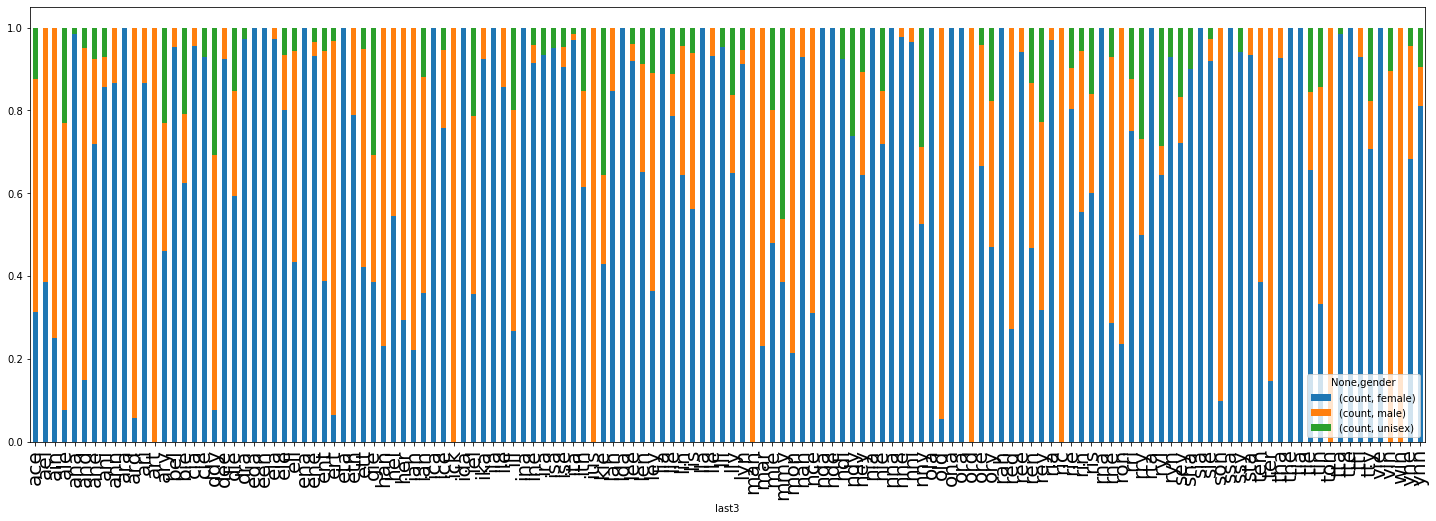

In [1116]:
data['last3']= data['name'].str[-3:]
data2=data[['last3', 'gender', 'name']].groupby(['last3', 'gender']).agg(['count'])
data2.reset_index(inplace=True)
data3=data[['last3', 'name']].groupby(['last3']).agg(['count'])
data3.reset_index(inplace=True)
data2.columns=['last3','gender','count']
data3.columns=['last3','tcount']
data4=data2.merge(data3, left_on='last3', right_on='last3')
data5=data4.sort_values(by=['tcount'], ascending=False)
data5=data5[:300]
tps2 = data5.pivot_table(values=['count'], 
                      index='last3',
                      columns='gender',
                      aggfunc='sum')


tps2 = tps2.div(tps2.sum(1), axis=0)
tps2.plot(kind='bar', stacked=True)

plt.gcf().set_size_inches(25, 8)

In [1040]:
tps2[tps2.iloc[:,0]>0.9]

count                    
gender    female      male    unisex
last3                               
ana     0.984375       NaN  0.015625
ann     0.864865  0.135135       NaN
ara     1.000000       NaN       NaN
ari     0.866667  0.133333       NaN
bel     0.952381  0.047619       NaN
cia     0.956522  0.043478       NaN
dra     0.971429       NaN  0.028571
eda     1.000000       NaN       NaN
een     1.000000       NaN       NaN
ela     0.972973  0.027027       NaN
ena     1.000000       NaN       NaN
ene     0.932203  0.033898  0.033898
eta     1.000000       NaN       NaN
ica     1.000000       NaN       NaN
ida     1.000000       NaN       NaN
ila     1.000000       NaN       NaN
ina     1.000000       NaN       NaN
ine     0.914634  0.042683  0.042683
isa     0.950000       NaN  0.050000
ise     0.904762  0.047619  0.047619
ita     0.970149  0.014925  0.014925
lda     1.000000       NaN       NaN
lee     0.918367  0.040816  0.040816
lia     1.000000       NaN       NaN
lla     1.000000       NaN       NaN
lle     0.931373  0.068627       NaN
lli     0.952381       NaN  0.047619
lyn     0.910714  0.035714  0.053571
nda     1.000000       NaN       NaN
nia     1.000000       NaN       NaN
nna     1.000000       NaN       NaN
nne     0.975904  0.024096       NaN
nni     0.965517  0.034483       NaN
ola     1.000000       NaN       NaN
ona     1.000000       NaN       NaN
ora     1.000000       NaN       NaN
rah     1.000000       NaN       NaN
ree     0.941176  0.058824       NaN
ria     0.970588  0.029412       NaN
rie     0.803279  0.098361  0.098361
sha     0.900000       NaN  0.100000
sia     1.000000       NaN       NaN
sie     0.918919  0.054054  0.027027
ssa     1.000000       NaN       NaN
ssy     0.941176       NaN  0.058824
sta     0.933333  0.066667       NaN
tha     0.925926  0.074074       NaN
the     1.000000       NaN       NaN
tia     1.000000       NaN       NaN
tta     0.984127       NaN  0.015873
tte     1.000000       NaN       NaN
ynn     0.809524  0.095238  0.095238

In [1118]:
tps2[tps2.iloc[:,1]>0.8]

count                    
gender    female      male    unisex
last3                               
ard     0.057692  0.942308       NaN
art          NaN  1.000000       NaN
ert     0.064516  0.903226  0.032258
ick          NaN  1.000000       NaN
ius          NaN  1.000000       NaN
man          NaN  1.000000       NaN
old     0.055556  0.944444       NaN
ord          NaN  1.000000       NaN
ric          NaN  1.000000       NaN
son     0.097561  0.902439       NaN
ter     0.147059  0.852941       NaN
ton          NaN  1.000000       NaN
vin          NaN  0.894737  0.105263
win          NaN  1.000000       NaN

Female - 'ana','ann','ara','bel','cia','dra','eda','een','ela','ena','ene','eta', 'ica','ida','ila','ina','ine','isa','ise','ita','lda','lee','lia','lie','lla','lle','lli','lyn','nda','nia','nna','nne','nni','ona','ora','ree','ria','rie','sha','sia','sie','ssa','ssy','tha','the','tia','tta','tte','ynn'
Male - 'ard','art','ert','ick','ius','man','ric','old','ord','son','ter''ton',tti','vin','win'

### First and last letters.

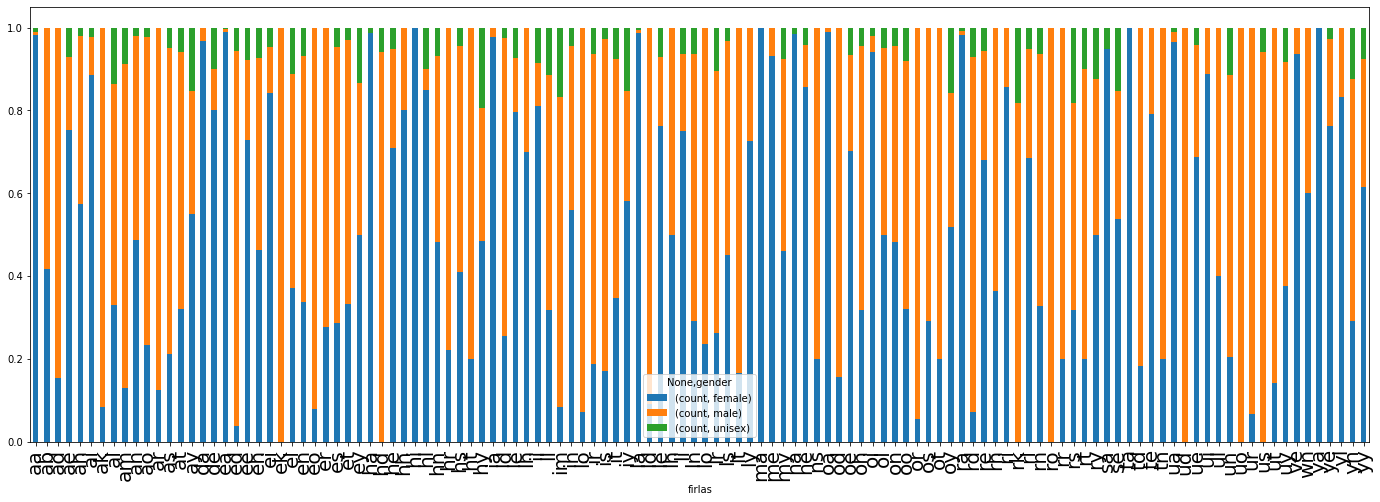

In [1100]:
data['firlas']= data['name'].str[1]+data['name'].str[-1]
data6=data[['firlas', 'gender', 'name']].groupby(['firlas', 'gender']).agg(['count'])
data6.reset_index(inplace=True)
data7=data[['firlas', 'name']].groupby(['firlas']).agg(['count'])
data7.reset_index(inplace=True)
data6.columns=['firlas','gender','count']
data7.columns=['firlas','tcount']
data8=data6.merge(data7, left_on='firlas', right_on='firlas')
data9=data8.sort_values(by=['tcount'], ascending=False)
data9=data9[:300]
tps2 = data9.pivot_table(values=['count'], 
                      index='firlas',
                      columns='gender',
                      aggfunc='sum')


tps2 = tps2.div(tps2.sum(1), axis=0)
tps2.plot(kind='bar', stacked=True)

plt.gcf().set_size_inches(24, 8)

In [1082]:
tps2[tps2.iloc[:,0]>0.9]

count                    
gender    female      male    unisex
firlas                              
aa      0.981524  0.006928  0.011547
da      0.966667  0.033333       NaN
ea      0.990323  0.006452  0.003226
ha      0.988235       NaN  0.011765
ia      0.977401  0.022599       NaN
la      0.986928  0.006536  0.006536
ma      1.000000       NaN       NaN
me      0.931034  0.068966       NaN
na      0.985294       NaN  0.014706
oa      0.990050  0.009950       NaN
oi      0.942308  0.038462  0.019231
ra      0.983193  0.008403  0.008403
sa      0.947368       NaN  0.052632
ta      1.000000       NaN       NaN
ua      0.965116  0.023256  0.011628
ve      0.937500  0.062500       NaN
ya      1.000000       NaN       NaN

In [1106]:
tps2[tps2.iloc[:,1]>0.85]

count                    
gender    female      male    unisex
firlas                              
ak      0.083333  0.916667       NaN
ar      0.125000  0.875000       NaN
ed      0.037037  0.907407  0.055556
ek           NaN  1.000000       NaN
eo      0.080000  0.920000       NaN
hd           NaN  0.941176  0.058824
io      0.071429  0.928571       NaN
ld      0.090909  0.909091       NaN
or      0.055556  0.944444       NaN
rd      0.071429  0.857143  0.071429
ro           NaN  1.000000       NaN
ud           NaN  1.000000       NaN
uo           NaN  1.000000       NaN
ur      0.066667  0.933333       NaN
us           NaN  0.941176  0.058824
ut      0.142857  0.857143       NaN

I will use 80% as cutoff point for good indicator.
For females, good indicators are 'aa','ai','da','ea','ei','ha','ia','id','ie','ii','il','la','ma','me','na','ne','oa','oi','ra','sa','ta','te','ua', 've','ya'. 
For males, good indicators are 
'ad','ak','am','ar', 'ed', 'ek','eo','hd','is','io','is','ld','od','or','rd','ro','ud','uo','ur','us','ut'. 

### Syllables

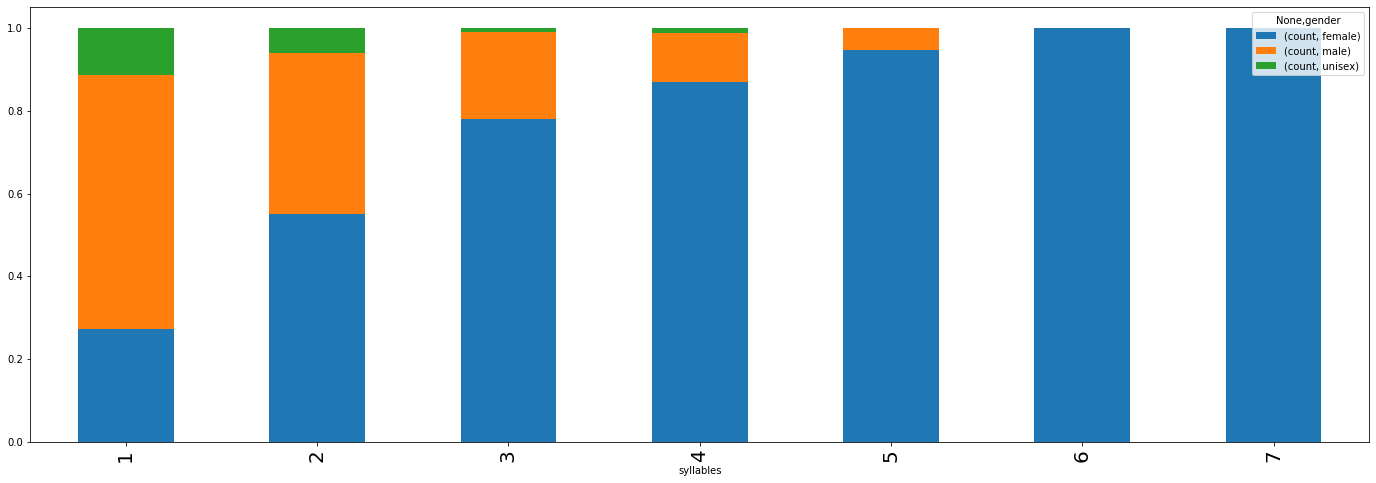

In [693]:
data1=data[['syllables', 'gender', 'name']].groupby(['syllables', 'gender']).agg(['count'])
data1.reset_index(inplace=True)
data1.columns = ['syllables','gender','count']
tps = data1.pivot_table(values=['count'],index='syllables',columns='gender',aggfunc='sum')
tps = tps.div(tps.sum(1), axis=0)
import matplotlib
matplotlib.rc('xtick', labelsize=20)  
%matplotlib inline 
tps.plot(kind='bar', stacked=True)
plt.gcf().set_size_inches(24, 8)

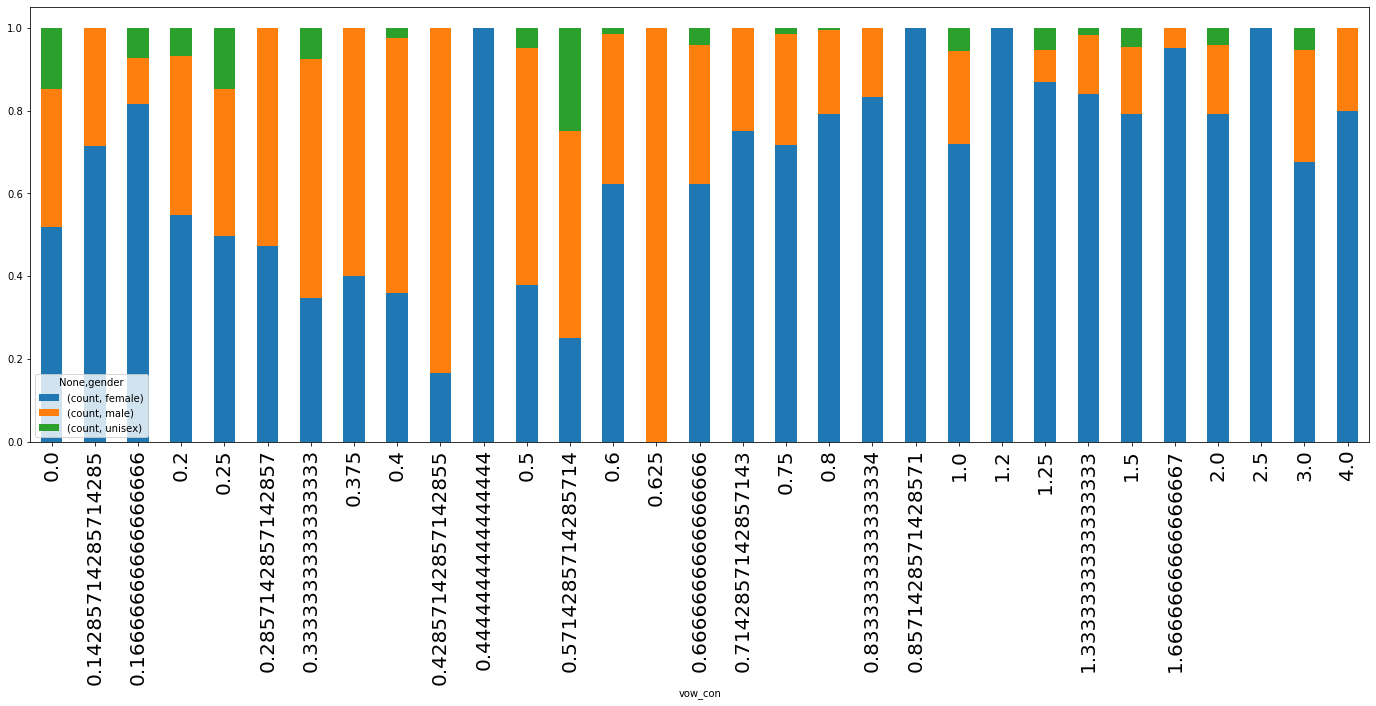

In [745]:
data['vow_con']=data['vowel_count']/data['consonant_count']
data1=data[['vow_con', 'gender', 'name']].groupby(['vow_con', 'gender']).agg(['count'])
data1.reset_index(inplace=True)
data1.columns = ['vow_con','gender','count']
tps = data1.pivot_table(values=['count'],index='vow_con',columns='gender',aggfunc='sum')
tps = tps.div(tps.sum(1), axis=0)
import matplotlib
matplotlib.rc('xtick', labelsize=20)  
%matplotlib inline 
tps.plot(kind='bar', stacked=True)
plt.gcf().set_size_inches(24, 8)

In [789]:
data1

,vow_con,gender,count
0,0.000000,female,14
1,0.000000,male,9
2,0.000000,unisex,4
3,0.142857,female,5
4,0.142857,male,2
5,0.166667,female,22
6,0.166667,male,3
7,0.166667,unisex,2
8,0.200000,female,57
9,0.200000,male,40


### Feature Generation Function
This function will be applied to our lists of names to create the features that we identified as potential predictors above in our initial model "kitchen sink" approach.  As we refine the model we will also refine this function to include only the features that seem most relevant to our classifier.  Vowel count, consonant count, and length have already been removed since they were found above to have no predictive value.  

In [58]:
# feature generator
def gender_features(name):
    # length of name
    length = len(name)
    
    # last letter, mll - for males and fll - for females
    last_letter = name[-1]
    mll=0
    if last_letter in 'cdfkmopvw':
        mll=1
    fll=0
    if last_letter in 'ai':
        fll=1    
    
    # Last 2 letters, mll2 - for males and fll2 - for females
    last2=name[-2:]
    mll2=0
    if last2 in ['ai','am','ar','as','ch','ck','co','dd','do','er','es','gi','ic','ik','it','io','lf','ld','lo','mo','ng',
                 'no','ns','od','om','on','os','ph','rd','rn','rs','rt','to','us']:
        mll2=1
    fll2=0
    if last2 in [ 'ca', 'da', 'di', 'ea','ee', 'ha', 'ia', 'ka','la', 'li', 'ma','mi','na', 'ne', 'ni', 'ra', 'sa','si',
                 'sy', 'ta', 'te','ti','va','ya','ye','yn']:
        fll2=1 
        
    last3=name[-3:]
    mll3=0
    if last3 in ['ard','art','ert','ick','ius','man','ric','old','ord','son','ter''ton','tti','vin','win']:
        mll3=1
    fll3=0
    if last3 in ['ana','ann','ara','bel','cia','dra','eda','een','ela','ena','ene','eta', 'ica','ida','ila','ina','ine',
                 'isa','ise','ita','lda','lee','lia','lie','lla','lle','lli','lyn','nda','nia','nna','nne','nni','ona',
                 'ora','ree','ria','rie','sha','sia','sie','ssa','ssy','tha','the','tia','tta','tte','ynn']:
        fll3=1     
    
    # Combination of last and first letters.mfl -for males, ffl - for females.
    fl=name[0]+name[-1:]  
    mfl=0
    if fl in ['ad','ak','am','ar', 'ed', 'ek','eo','hd','is','io','is','ld','od','or','rd','ro','ud','uo','ur','us','ut']:
        mfl=1
    ffl=0
    if fl in ['aa','ai','da','ea','ei','ha','ia','id','ie','ii','il','la','ma','me','na','ne','oa','oi','ra','sa','ta',
              'te','ua', 've','ya']:
        ffl=1 
  
    # Combination of vowels.mv -for males, fv - for females.
    vowels =set("AeEeIiOoUu")
    
    vow=''
    for i in name:
        if i in vowels:
            vow=vow+i
    print(vow)    
    mv=0
    if vow in ['eo','iea','io']:
        mv=1
    fv=0
    if vow in ['aaa','aaea','aaee','aaia','aaie','aea','aee','aea','aee','aia','eea','eia','iia','oea','oee','oia']:
        fv=1 
  
    syll= len(SSP.tokenize(name))
    syllc=0
    if syll>3:
        syllc=1
        
    vowel=set("AeEeIiOoUu")
    vcount=0
    for alphabet in name: 
      
        # If alphabet is present 
        # in set vowel 
        if alphabet in vowel: 
            vcount = vcount + 1
    ccount=len(name)-vcount
    vow_con=vcount/ccount
    
    fvc=0
    if vow_con>=0.7 or vow_con==1/6 or vow_con==4/9:
        fvc=1
        
    return {
        'name':name,
        'fll':fll,
        'mll':mll,
        'fll2':fll2,
        'mll2':mll2,
        'mfl':mfl,
        'ffl':ffl,
        #'syllc':syllc,
        #'fvc':fvc,
        #'mll3':mll3,
        'fll3':fll3,
        'mv':mv,
        'fv':fv
        
    }

## Data Preparation
We need to apply our feature generation function to our list of names and then split the lists into training, test, and validation sets.

In [59]:
random.shuffle(all_names)
all_names1 = [(gender_features(name), gender) for (name, gender) in all_names]


# create each set of data
dev_set = all_names1[:1000]
test = all_names1[-6900:]

# split the development set into initial training and test sets
train = dev_set[:500]
dev_test = dev_set[500:]


train[:10]

ue
eue
o
i
oi
ie
e
ii
ie
e
uie
ii
ie
ie
ee
ii
eie
ei
eie
e
eoie
ue
oo
e
iee
eei
e
e
iie
iee
oi
ie
e
u
uii
i
eeie
oie
eue
e
ee
e
ei
i
ii
oie
ueee

iie
i

u
i

i
ie
eoie
e
oo
i
uie
e
i
i
eio
ioe
i
i
ie
i
ie
oie
ei
eu


ee
oe
ii
ii
o
i
ee
e
ee
e
e
eoe
oi
io
ouie
ie
e
eii
e

e
eie
ei
e
ei
uo
eei
ee
oo
ie
eie
ee
iei
oeio
o
eee
e

o
oi
e
oie
eo
ei
ui
e
ei
oi
u
oi
ie

ioe
o
eo
o
i
ee
iee
u


ui
o
i
e
ei
u
i
ie
o
io
o
ie
e
iu
eie
e
oeo
ei
ei
e
iee
e
uei
oe
ioe
ei
e
o
ee
ee
ioe
oe
ei
io
oi
oio
ie
iee
oe
ei
e
i
iie
oie
e
ioi
eie
i
ii
e
oe
e
ee
ee
ei
ue
eiue
ee
e
ii
ee
eo

i
ii
ie
ue
e
ei
oo
iie
ei
e
i
ee
eie
o
i
eui
eie
e
iie
e
i
ee
e

u
eie
oie
i
o
e
iie
oeio
ei
uie
i

u
e
ee
eie
e
i
o
i
u
eio
eiee
oie
eie
i
ee
ie

iee
eo
io

oe
e
eei
ouie
o
oi
ee
oee
ue
o

e
o
ie
u
ei
ui
e

ui
i
ee
o
ei
o
e
eo
uiee
i
oi
ii
ee
ie
ie
i

ie
i
uee

eeee
ui
eo
ie

o

ui
eie
i
oe
ioee
ueo
o
oe
e
i
e

eo
e
oo
oo
o

eei
oi
eoie
i
e

ie
ei
ee
ee
ii
oi
eo
oeie
ee
ii
io
o
i
o
e
e
ie
oiee


oee
o
e

i
e
e
e
eiee
ee
ie
oe


eue
iie
e
ee
e
ee
e
eie
oee
eoi

ii
ie
ie
ui
uie
ee
e
u
o
ee
u
ee
e
ee

oe
oe
e
e
ooe
oi
e
i
eee
iie

e
ee
oie
ui
ie
oie
ee
ei
o
u
eo
e
eueie
ei
e
oo
i
o
i
e
ee
ei
i
i
ie
ie
iei
o
oe
o
ie
eoo
uu
u
o
o
e

e

i
ei

eie
e
ioe

e
eie

ue
i
i
e
oei
iue
i
i
ue
eei
i
eo
iee
ee
iee
eee
ei
ie

e
i
ie
ue

e
i
ei
ui
e

o
eoee

eie
i
e



ie
o
ie
o
e
ie
e
oe
ii
ei
eo
e
ie
ie
e
o
i
ie
oie
i
ee
e
o
ei
ii
i
io
ie
oe
ue
i
ee

ie
eie
eie
ee
iie
o

eo
i
ii
ei
ie
ie
iu

ee
eie
oe
eoo
ee
eei
e
ie

e
ie
ee
oo
ee
ui
oi
o

ei
i
oie
ee

ei
i
i
o
ei
i
i
oie
oi
e
oii
e
e

o
e

o
e

e
i
ei
oei
o
oee
e
ei

o
oe
eoi
ue
e
e
e
o
e

e
ee
ioi
i
ee
uo
ii
i
oiue
uieee
ie
io
ie
eoi
ue

uie
eo
euee
oee
i
ie
e

e
e
i
i

oie
o

ei
ui
i
i
i

e
eee
io
eoe
oi
eo
e
e
eie

i
ioi
o
ee
eio
ei
eie
ie
e
iie
e
ii
ee


ei
ii

e
i
ou
u
o
ei
ei
o
e
e
o
i
ee
i
i
oi
e
ee
o
ie
oe
oee
i
eeoo
iee

oie
oe
ei
e
iie
e
ueie
ei
i
io
e
ie
e
ie
i
e


eie
uiue
ei
oiie
io
eio
ie
ee

ou
ioe
ei
e
eee
ee
ie
uiu
ee
e
e
ee
eoi

e
ei
ie
iee
o
eo
u
iei
i
oe

eie
i
ue
i
eoe
ooi
ee
ii
o

oie
iue
oee
eie
ee
u
e
ee
eei
iie
i
e
eie
e
ie
e

io

ii
eee
iu

oe
iie
oi

ue
ie
i
ee
ue
eo
ei
i
e
oie
oee


e
eoie
io
e
e
ee
ee

ooe
o
e
u
oie
ei
iei
ioe
eo
eo
iu
ei
i
ie
o
o
ei
ei
ieo
ei
eeie
iee
o
ee
eu
i
iie
ei
euee
oi
ie
e
ue
o
e
iio
o
uie
ee
oio
ue

e
ii
i
iio
ee
eo

e
ie
i
ie
ee
eo
e

e

o
e
eeio
iee
e
o
ie
i
o
ei
io
o
ie
ie
ioe
o
eie
ee
e

oie
ei

ie
ooe
e
ee
oe
eie
o
o
ee
ie
oi
eii
o
iei
eoi
iou
euo
oie
eeie
u
io
ie
ue

eou

ee
ui
eee
eie
ei
i

o
e
e
oie
ee
o
uui

ee
iie
e
i
ie

ioe

eie
iie

uieee
e
ie
ie
o
oi
o
oeie
ue
eo
ei
o
o
ei
e
ei
i
e

o
iii

ii
eie
ue
i
i


ue
oe
e
ei
ui
e

e
u
ei
ie
i

eu
ie
e

ei
eiee
ee
ie
ui
ei
i

u
ei

ie
i
ie
ieo
ee
ii
ee
e
o
eoo
ie
oiee
ie
oi
u
ii
ie
i
e
i
e
ii
ee
e
oi
ieu
e
e
oie

uei
oe
ie
i
o
e
oe
oo

ie
eo
ui
ioe
oi
oe
i
ue
e
ou
ii
ie
iie
o


o
e
e
i
o
oue
eie
ie
i

u

eu
ui
e
e

ooe
ei
i

i
ei
ei
i
ie

i
oi
e
oi
eie
oe
e
ie
ie
ee
e
e
oei
ee
iii
oee
e
eoe
ii
u
ie
ee
eo
oe
e
eie
ee
ei
i
u

e
eo
ei
i
oeu
oei
e
oi


[({'name': 'hurley',
   'fll': 0,
   'mll': 0,
   'fll2': 0,
   'mll2': 0,
   'mfl': 0,
   'ffl': 0,
   'fll3': 0,
   'mv': 0,
   'fv': 0},
  'male'),
 ({'name': 'eustace',
   'fll': 0,
   'mll': 0,
   'fll2': 0,
   'mll2': 0,
   'mfl': 0,
   'ffl': 0,
   'fll3': 0,
   'mv': 0,
   'fv': 0},
  'male'),
 ({'name': 'goddart',
   'fll': 0,
   'mll': 0,
   'fll2': 0,
   'mll2': 1,
   'mfl': 0,
   'ffl': 0,
   'fll3': 0,
   'mv': 0,
   'fv': 0},
  'male'),
 ({'name': 'magdaia',
   'fll': 1,
   'mll': 0,
   'fll2': 1,
   'mll2': 0,
   'mfl': 0,
   'ffl': 1,
   'fll3': 0,
   'mv': 0,
   'fv': 0},
  'female'),
 ({'name': 'florri',
   'fll': 1,
   'mll': 0,
   'fll2': 0,
   'mll2': 0,
   'mfl': 0,
   'ffl': 0,
   'fll3': 0,
   'mv': 0,
   'fv': 0},
  'female'),
 ({'name': 'shaine',
   'fll': 0,
   'mll': 0,
   'fll2': 1,
   'mll2': 0,
   'mfl': 0,
   'ffl': 0,
   'fll3': 1,
   'mv': 0,
   'fv': 0},
  'unisex'),
 ({'name': 'sherman',
   'fll': 0,
   'mll': 0,
   'fll2': 0,
   'mll2': 0,
   'mfl':

In [60]:
import nltk
classifier = nltk.NaiveBayesClassifier.train(train)

nltk.classify.accuracy(classifier, dev_test)

0.744

In [61]:
classifier.show_most_informative_features(25)

Most Informative Features
                     mll = 1                male : female =     22.6 : 1.0
                     fll = 1              female : male   =     22.1 : 1.0
                    mll2 = 1                male : female =     14.4 : 1.0
                    fll3 = 1              female : male   =     13.4 : 1.0
                    fll2 = 1              female : male   =     10.1 : 1.0
                     mfl = 1                male : female =      8.5 : 1.0
                     ffl = 1              female : male   =      7.0 : 1.0
                      mv = 1                male : female =      6.2 : 1.0
                    fll2 = 0                male : female =      2.0 : 1.0
                    fll3 = 0                male : female =      1.8 : 1.0
                     fll = 0                male : female =      1.7 : 1.0
                    mll2 = 0              female : male   =      1.5 : 1.0
                     ffl = 0              unisex : female =      1.3 : 1.0

In [54]:
errors = []
for (name, tag) in dev_test:
    #print(name)
    #type(name)
    guess = classifier.classify(name)
    #print('step1')
    if guess!= tag:
        errors.append((tag, guess, list(name.values())[0]))

In [49]:
for (tag, guess, name) in sorted(errors):
    print('correct={:<8} guess={:<8s} name={:<30}'.format(tag, guess, name))

correct=female   guess=male     name=agnese                        
correct=female   guess=male     name=alyce                         
correct=female   guess=male     name=amandy                        
correct=female   guess=male     name=amargo                        
correct=female   guess=male     name=angy                          
correct=female   guess=male     name=anne-mar                      
correct=female   guess=male     name=ansley                        
correct=female   guess=male     name=arlen                         
correct=female   guess=male     name=avrit                         
correct=female   guess=male     name=bamby                         
correct=female   guess=male     name=bell                          
correct=female   guess=male     name=binny                         
correct=female   guess=male     name=blaire                        
correct=female   guess=male     name=brunhilde                     
correct=female   guess=male     name=carlen     